## AR Frequency
**Author: Deanna Nash**

Plot the frequency (percent of time steps) that an AR occurred in western US between November 2016 - February 2017. Also plot the landfall frequency of ARs making landfall in the western US.

In [1]:
# Import Python modules
import os, sys
import numpy as np
import pandas as  pd
import xarray as xr
from datetime import datetime, timedelta
# plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import seaborn as sns
import cmocean.cm as cmo
import cmocean
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from pathlib import Path
from IPython.display import Image, display
from scipy.ndimage import gaussian_filter    # smoothing contour lines

# Path to modules
sys.path.append('../python_scripts')

# Import my modules
from plotter import draw_basemap, make_cmap

### Set up paths

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/USWest_Water/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/USWest_Water/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'


In [4]:
# label strings
ivt_units = 'kg m$^{-1}$ s$^{-1}$'

# Select lat/lon grid
bnds = [150, 360-70, 10, 60]
lonmin, lonmax, latmin, latmax = bnds

# set start and end dates
start_date = '2016-11-01 9:00'
end_date = '2017-03-01 9:00'

## Calculate AR climatology

In [5]:
%%time
ar_filename = path_to_data + 'ar_catalog/globalARcatalog_ERA-Interim_1979-2019_v3.0.nc'
ds = xr.open_dataset(ar_filename)

CPU times: user 106 ms, sys: 26.3 ms, total: 132 ms
Wall time: 141 ms


In [5]:

# ds = ds.assign_coords(lon=(((ds.lon + 180) % 360)-180))

ar_ds = ds.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
ar_ds = ar_ds.shape.squeeze()
ar_ds


# # percent of time steps
# # count number of AR time steps 
# count_NDJF = len(ar_ds)
# # count number of AR time steps per gridcell
# ar_da = np.divide(ar_ds.count(dim='time'), count_NDJF)

# number of days
ar_da = ar_ds.count(dim='time')/4.
ar_da

CPU times: user 259 ms, sys: 41.3 ms, total: 301 ms
Wall time: 309 ms


<xarray.DataArray 'shape' (lat: 34, lon: 94)>
array([[1.25, 1.5 , 1.  , ..., 0.  , 0.25, 0.5 ],
       [1.5 , 1.  , 0.75, ..., 0.5 , 0.5 , 0.25],
       [1.5 , 0.75, 0.75, ..., 0.5 , 0.25, 0.25],
       ...,
       [3.25, 3.5 , 5.75, ..., 7.75, 8.  , 7.5 ],
       [7.  , 7.75, 9.  , ..., 5.75, 6.25, 5.75],
       [3.  , 4.5 , 5.75, ..., 4.5 , 5.25, 5.5 ]])
Coordinates:
  * lon      (lon) float64 150.0 151.5 153.0 154.5 ... 285.0 286.5 288.0 289.5
  * lat      (lat) float64 10.5 12.0 13.5 15.0 16.5 ... 54.0 55.5 57.0 58.5 60.0
    lev      float64 1e+03
    ens      float64 1.0

## Create figure

In [12]:
# Set up projection
mapcrs = ccrs.PlateCarree(central_longitude=180.0, globe=None)
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+10,10)

# Data for plotting
data = ar_da
lons = data.lon.values
lats = data.lat.values

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


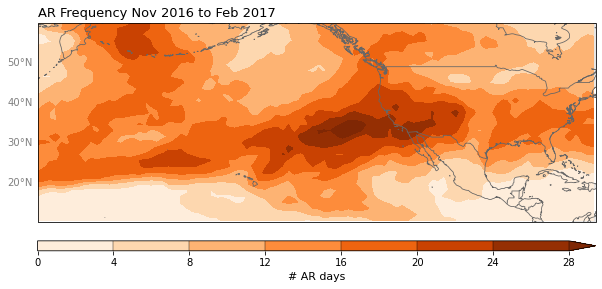

In [13]:
# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.25,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.01, cbar_size='5%',label_mode='')

# cmap setup
cmap = 'Oranges'
cflevs = np.arange(0, 32, 2)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled

    cf = ax.contourf(lons, lats, data.values, transform=datacrs,
                    cmap=cmap, extend='max')
    
    # Subtitles
    ax.set_title('AR Frequency Nov 2016 to Feb 2017', loc='left', fontsize=13)

# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('# AR days', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Save figure
filepath = path_to_figs + 'AR_freq_nov2016_feb2017' + '.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

## Number of AR Landfalls

In [16]:
# Select lat/lon grid
bnds = [360-130, 360-110, 10, 55] # west coast us bounds
lonmin, lonmax, latmin, latmax = bnds
da = ds.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
da = da.kidmap.squeeze()
da

<xarray.DataArray 'kidmap' (time: 480, lat: 30, lon: 13)>
[187200 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 231.0 232.5 234.0 235.5 ... 244.5 246.0 247.5 249.0
  * lat      (lat) float64 10.5 12.0 13.5 15.0 16.5 ... 48.0 49.5 51.0 52.5 54.0
    lev      float64 1e+03
  * time     (time) datetime64[ns] 2016-11-01T12:00:00 ... 2017-03-01T06:00:00
    ens      float64 1.0
Attributes:
    long_name:  Track ID
    units:      none

In [19]:

# create list of lists of trackIDs for each time step
date_lst = da.time.values
final_lst = []
for i, ids in enumerate(date_lst):
#     print(ids)
    # pull track ID list for each time step
    x = da.sel(time=ids).values.flatten()
    result = x[np.logical_not(np.isnan(x))]
    trackID = np.unique(result)
    for j in range(len(trackID)):
        final_lst.append([ids, trackID[j]])
    
# put final_lst into df
track_df = pd.DataFrame(final_lst, columns=['date', 'trackID'])
track_df
track_ids = track_df.trackID.unique()
# create df with trackID, start date, end date, and duration of AR
data = []
for i, ids in enumerate(track_ids):
    idx = (track_df.trackID == ids)
    test = track_df.loc[idx]
    start = test.date.min()
    stop = test.date.max()
    tmp = (test.date.max() - test.date.min()) + timedelta(hours=6)
    duration = tmp.total_seconds()/(3600) # convert to number of hours
    
    data.append([ids, start, stop, duration])
    
duration_df = pd.DataFrame(data, columns=['trackID', 'start_date', 'end_date', 'duration'])
duration_df

,trackID,start_date,end_date,duration
0,120502.0,2016-11-01 12:00:00,2016-11-01 12:00:00,6.0
1,120504.0,2016-11-01 18:00:00,2016-11-06 18:00:00,126.0
2,120509.0,2016-11-02 00:00:00,2016-11-02 00:00:00,6.0
3,120508.0,2016-11-03 06:00:00,2016-11-03 06:00:00,6.0
4,120520.0,2016-11-03 18:00:00,2016-11-03 18:00:00,6.0
...,...,...,...,...
74,121430.0,2017-02-19 06:00:00,2017-02-19 18:00:00,18.0
75,121438.0,2017-02-20 00:00:00,2017-02-22 06:00:00,60.0
76,121458.0,2017-02-22 18:00:00,2017-02-23 06:00:00,18.0
77,121483.0,2017-02-25 18:00:00,2017-02-25 18:00:00,6.0


In [22]:
ds

<xarray.Dataset>
Dimensions:      (ens: 1, lat: 121, lev: 1, lon: 240, time: 59412)
Coordinates:
  * lon          (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
  * lat          (lat) float64 -90.0 -88.5 -87.0 -85.5 ... 85.5 87.0 88.5 90.0
  * lev          (lev) float64 1e+03
  * time         (time) datetime64[ns] 1979-01-01 ... 2019-08-31T18:00:00
  * ens          (ens) float64 1.0
Data variables:
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    shape        (ens, time, lev, lat, lon) float32 ...
    axis         (ens, time, lev, lat, lon) float64 ...
    tnsct        (ens, time, lev, lat, lon) float64 ...
    lfloc        (ens, time, lev, lat, lon) float32 ...
    kidmap       (ens, time, lev, lat, lon) float64 ...
    kstatusmap   (ens, time, lev, lat, lon) float32 ...
    year         (ens, time, lev, lat) float64 ...
    month        (ens, time, lev, lat) float64 ...
    day          (ens, time, lev, lat) float64 ...
    hour         (ens, time, lev, lat) float64 ...
    length       (ens, time, lev, lat) float64 ...
    width        (ens, time, lev, lat) float64 ...
    clon         (ens, time, lev, lat) float64 ...
    clat         (ens, time, lev, lat) float64 ...
    tlon         (ens, time, lev, lat) float64 ...
    tlat         (ens, time, lev, lat) float64 ...
    hlon         (ens, time, lev, lat) float64 ...
    hlat         (ens, time, lev, lat) float64 ...
    ivtx         (ens, time, lev, lat) float64 ...
    ivty         (ens, time, lev, lat) float64 ...
    ivtdir       (ens, time, lev, lat) float64 ...
    ivtdircoh    (ens, time, lev, lat) float64 ...
    width2       (ens, time, lev, lat) float64 ...
    tivt         (ens, time, lev, lat) float64 ...
    lflon        (ens, time, lev, lat) float64 ...
    lflat        (ens, time, lev, lat) float64 ...
    lfivtx       (ens, time, lev, lat) float64 ...
    lfivty       (ens, time, lev, lat) float64 ...
    lfivtdir     (ens, time, lev, lat) float64 ...
    kid          (ens, time, lev, lat) float64 ...
    kstatus      (ens, time, lev, lat) float64 ...
    klifetime    (ens, time, lev, lat) float64 ...
    kdist        (ens, time, lev, lat) float64 ...
    kspeed       (ens, time, lev, lat) float64 ...
    knormage     (ens, time, lev, lat) float64 ...
    kivtx        (ens, time, lev, lat) float64 ...
    kivty        (ens, time, lev, lat) float64 ...
    kivtdir      (ens, time, lev, lat) float64 ...
    kdispx       (ens, time, lev, lat) float64 ...
    kdispy       (ens, time, lev, lat) float64 ...
    kdispdir     (ens, time, lev, lat) float64 ...
    kinstvelx    (ens, time, lev, lat) float64 ...
    kinstvely    (ens, time, lev, lat) float64 ...
    kinstveldir  (ens, time, lev, lat) float64 ...
    axisidx      (ens, time, lev, lat, lon) float64 ...
    axislon      (ens, time, lev, lat, lon) float64 ...
    axislat      (ens, time, lev, lat, lon) float64 ...
    xtnsctidx    (ens, time, lev, lat, lon) float64 ...
    numobj       (ens, time, lev, lat, lon) float32 ...
    kcnt         (ens, time, lev) float64 ...
Attributes:
    title:           Global Atmospheric River Database
    version:         2020.02.13
    creation_date:   13-Feb-2020 16:36:39
    tARget_version:  3
    references:      (1) Guan, B., and D. E. Waliser (2015), Detection of atm...

In [30]:
tmp = ds.sel(time=slice(start_date, end_date))
kivty = tmp.kivty.squeeze() # ivty for each trackID
kivtx = tmp.kivtx.squeeze() # ivtx for each trackID
kid = tmp.kid.squeeze() # trackID for indexing
kid
# append ivty and ivtx to df for each trackID
ivty = []
ivtx = []
trID = []

for i, track in enumerate(duration_df.trackID.values):
    idx = kivtx.where(kid == track, drop=True).values
    x = idx[~np.isnan(idx)][0]
    idy = kivty.where(kid == track, drop=True).values
    y = idy[~np.isnan(idy)][0]
    
    # append to lists
    ivtx.append(x)
    ivty.append(y)
    trID.append(track)


In [31]:
duration_df['ivty'] = ivty
duration_df['ivtx'] = ivtx
duration_df['ivt'] = np.sqrt(duration_df.ivty**2 + duration_df.ivtx**2)
duration_df

,trackID,start_date,end_date,duration,ivty,ivtx,ivt
0,120502.0,2016-11-01 12:00:00,2016-11-01 12:00:00,6.0,76.761020,162.614105,179.821026
1,120504.0,2016-11-01 18:00:00,2016-11-06 18:00:00,126.0,161.330699,283.047401,325.796602
2,120509.0,2016-11-02 00:00:00,2016-11-02 00:00:00,6.0,76.974388,157.589072,175.383499
3,120508.0,2016-11-03 06:00:00,2016-11-03 06:00:00,6.0,90.024845,-240.117509,256.438864
4,120520.0,2016-11-03 18:00:00,2016-11-03 18:00:00,6.0,68.136771,-485.849208,490.603784
...,...,...,...,...,...,...,...
74,121430.0,2017-02-19 06:00:00,2017-02-19 18:00:00,18.0,179.254082,140.538874,227.778843
75,121438.0,2017-02-20 00:00:00,2017-02-22 06:00:00,60.0,112.571092,209.337391,237.685494
76,121458.0,2017-02-22 18:00:00,2017-02-23 06:00:00,18.0,67.730040,188.490808,200.290147
77,121483.0,2017-02-25 18:00:00,2017-02-25 18:00:00,6.0,112.428408,256.220125,279.801535


In [32]:
outfile = path_to_out + 'AR_track_duration_USwest_nov2016_feb2017.csv'
duration_df.to_csv(outfile)

## Landfall Locations

In [6]:
# Select lat/lon grid


bnds = [-180, 180, -90, 90] # global bounds
lonmin, lonmax, latmin, latmax = bnds
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360)-180))


In [7]:
# climatological number of landfall days
clim_ct = ds.lfloc.count(dim='time')
clim_len = len(ds.lfloc.time)
clim_freq = (clim_ct/clim_len)*365.25
clim_freq = clim_freq.squeeze().values

index_clim = np.flatnonzero(clim_freq)
print(index_clim.shape)
landfall_clim = clim_freq.ravel()[index_clim]
print(landfall_clim.shape)

clim_lons, clim_lats = np.meshgrid(ds.lon, ds.lat)
clim_lat_list = clim_lats.ravel()[index_clim]
print(clim_lat_list.shape)
clim_lon_list = clim_lons.ravel()[index_clim]
print(clim_lon_list.shape)

(1078,)
(1078,)
(1078,)
(1078,)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


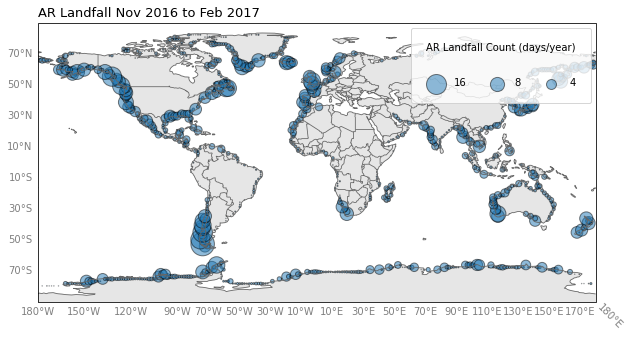

In [8]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations

dx = np.arange(lonmin,lonmax+20,10)
dy = np.arange(latmin,latmax+20,20)

# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.25,label_mode='')

# cmap setup
cmap = 'Oranges'
cflevs = np.arange(0, 32, 2)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
#     ax = draw_basemap(ax,  extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    ax = draw_basemap(ax, xticks=dx, yticks=dy)
    
    # Bubbles
    x = clim_lon_list
    y = clim_lat_list 
    z = landfall_clim
    scl = 25
    sc = ax.scatter(x, y, s=z*scl, c='tab:blue', marker='o', alpha=0.5, transform=mapcrs, edgecolors='k')
    
    # Subtitles
    ax.set_title('AR Landfall Nov 2016 to Feb 2017', loc='left', fontsize=13)
    
    # legend
    
    msizes = [16*scl, 8*scl, 4*scl]
    markers = []
    for size in msizes:
        markers.append(plt.scatter([],[], s=size, c='tab:blue', edgecolors='k', label=(int(size/scl)), alpha=0.5))

    ax.legend(handles=markers, loc='upper right', labelspacing=2.5, borderpad=1.5, title='AR Landfall Count (days/year)', ncol=3)
    
# Save figure
filepath = path_to_figs + 'AR_clim_landfall_nov2016_feb2017' + '.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

In [9]:
# subset to WY2017
# ar_ds = ds.sel(time=slice(start_date, end_date), lat=slice(latmin, latmax))
ar_ds = ds.sel(time=slice(start_date, end_date))

# number of landfall days
ar_ct = ar_ds.lfloc.count(dim='time')
ar_len = len(ar_ds.lfloc.time)
landfall_freq = (ar_ct/ar_len)*365.25
landfall_freq = landfall_freq.squeeze().values

index_landfall = np.flatnonzero(landfall_freq)
print(index_landfall.shape)
landfall_list = landfall_freq.ravel()[index_landfall]
print(landfall_list.shape)

mesh_lons, mesh_lats = np.meshgrid(ar_ds.lon, ar_ds.lat)
lat_list = mesh_lats.ravel()[index_landfall]
print(lat_list.shape)
lon_list = mesh_lons.ravel()[index_landfall]
print(lon_list.shape)

(332,)
(332,)
(332,)
(332,)


In [10]:
landfall_list

array([ 0.7609375,  0.7609375,  0.7609375,  2.2828125,  0.7609375,
        0.7609375,  0.7609375,  0.7609375,  0.7609375,  0.7609375,
        7.609375 ,  3.8046875,  2.2828125,  1.521875 ,  2.2828125,
        3.04375  ,  9.13125  ,  3.8046875,  3.8046875,  0.7609375,
        0.7609375,  0.7609375,  0.7609375,  0.7609375,  2.2828125,
        1.521875 ,  0.7609375,  0.7609375,  0.7609375,  0.7609375,
        0.7609375,  0.7609375,  4.565625 ,  0.7609375,  2.2828125,
        3.04375  ,  0.7609375,  2.2828125,  0.7609375,  0.7609375,
        0.7609375,  0.7609375,  0.7609375,  0.7609375,  0.7609375,
        0.7609375,  3.04375  ,  1.521875 ,  3.04375  ,  0.7609375,
        0.7609375,  3.04375  ,  1.521875 ,  2.2828125,  1.521875 ,
        2.2828125,  4.565625 ,  0.7609375,  8.3703125,  1.521875 ,
        0.7609375,  0.7609375,  0.7609375,  0.7609375,  0.7609375,
        1.521875 ,  0.7609375,  0.7609375,  8.3703125,  3.8046875,
        0.7609375,  0.7609375,  2.2828125,  1.521875 ,  2.2828

In [11]:
lat_list

array([-78. , -78. , -78. , -78. , -78. , -78. , -78. , -78. , -78. ,
       -78. , -76.5, -76.5, -76.5, -76.5, -76.5, -76.5, -75. , -75. ,
       -75. , -75. , -75. , -75. , -75. , -75. , -75. , -73.5, -73.5,
       -73.5, -73.5, -73.5, -73.5, -73.5, -73.5, -72. , -72. , -72. ,
       -72. , -72. , -72. , -72. , -70.5, -70.5, -70.5, -70.5, -70.5,
       -70.5, -70.5, -70.5, -70.5, -70.5, -69. , -69. , -69. , -69. ,
       -69. , -69. , -69. , -67.5, -67.5, -67.5, -67.5, -67.5, -67.5,
       -67.5, -67.5, -67.5, -67.5, -67.5, -67.5, -67.5, -67.5, -67.5,
       -66. , -66. , -66. , -66. , -66. , -66. , -66. , -66. , -54. ,
       -54. , -52.5, -51. , -49.5, -48. , -46.5, -45. , -45. , -43.5,
       -43.5, -42. , -40.5, -39. , -39. , -37.5, -37.5, -36. , -36. ,
       -36. , -36. , -34.5, -34.5, -34.5, -33. , -33. , -33. , -33. ,
       -33. , -30. , -30. , -28.5, -27. , -25.5, -24. , -24. , -24. ,
       -22.5, -22.5, -22.5, -22.5, -21. , -21. , -21. , -21. , -19.5,
       -19.5, -18. ,

In [12]:
lon_list

array([ 177. , -162. , -160.5, -159. , -150. ,  -54. ,  -51. ,  -49.5,
        -39. ,  -36. , -148.5, -147. , -145.5, -144. ,  -55.5,  -28.5,
       -138. , -133.5, -132. , -129. , -124.5, -120. , -115.5, -108. ,
        -24. , -102. ,  -93. ,  -88.5,  -85.5,  -84. ,  -81. ,  -79.5,
        -19.5,  166.5, -100.5,  -99. ,  -97.5,  -13.5,  -12. ,  -10.5,
          0. ,    3. ,   12. ,   22.5,   25.5,   27. ,  163.5,  -73.5,
        -72. ,  -70.5,   34.5,   40.5,   72. ,   78. ,  153. ,  154.5,
        156. ,   46.5,   63. ,   82.5,   85.5,  114. ,  117. ,  118.5,
        123. ,  130.5,  142.5,  144. ,  145.5,  -67.5,  -66. ,  -61.5,
         96. ,   97.5,   99. ,  100.5,  103.5,  105. ,  135. ,  -64.5,
        -72. ,  -70.5,  -73.5,  -73.5,  -75. ,  -73.5,  -73.5,  168. ,
        -73.5,  171. ,  -72. ,  -73.5,  -73.5,  175.5,  -72. ,  141. ,
        -73.5,  141. ,  174. ,  -72. ,  -58.5,  117. ,  138. ,  -55.5,
         19.5,  117. ,  135. ,  151.5,  -70.5,  115.5,  153. ,   16.5,
      

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


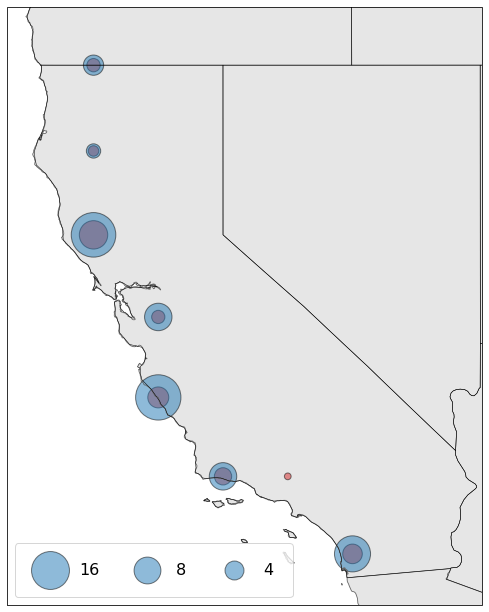

In [32]:
# Set up projection
mapcrs = ccrs.Mercator()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations

dx = np.arange(lonmin,lonmax+20,10)
dy = np.arange(latmin,latmax+20,20)

# Create figure
fig = plt.figure(figsize=(10,11))
nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.25,label_mode='')

# cmap setup
cmap = 'Oranges'
cflevs = np.arange(0, 32, 2)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax,  extent=[-125,-114,32,43], xticks=dx, yticks=dy)
#     ax = draw_basemap(ax, xticks=dx, yticks=dy)
    # Download and add the states and coastlines
    states = cfeature.NaturalEarthFeature(category="cultural", scale="50m",
                                 facecolor="none",
                                 name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=.5, edgecolor="black")
    
    # Climatology Bubbles
    x = clim_lon_list
    y = clim_lat_list 
    z = landfall_clim
    scl = 90
    sc = ax.scatter(x, y, s=z*scl, c='tab:red', marker='o', alpha=0.5, transform=datacrs, edgecolors='k')
    
    # Bubbles
    x = lon_list
    y = lat_list 
    z = landfall_list
    sc = ax.scatter(x, y, s=z*scl, c='tab:blue', marker='o', alpha=0.5, transform=datacrs, edgecolors='k')
    
    # Subtitles
#     ax.set_title('AR Landfall Nov 2016 to Feb 2017', loc='left', fontsize=13)
    
    # legend
    
    msizes = [16*scl, 8*scl, 4*scl]
    markers = []
    for size in msizes:
        markers.append(plt.scatter([],[], s=size, c='tab:blue', edgecolors='k', label=(int(size/scl)), alpha=0.5))

    ax.legend(handles=markers, loc='lower left', labelspacing=2.4, borderpad=1.2, 
               ncol=3, prop={'size': 16})
    
# Save figure
filepath = path_to_figs + 'AR_landfall_nov2016_feb2017' + '.png'
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()

